In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas_datareader import data as pdr 
import math 
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
%matplotlib inline
print('libraries imported')

libraries imported


### Download the Financial Data : Historical stock price

* In this project I used python package yfinance to download historical  stock prices
* For more information about this python package, please visit https://pypi.org/project/yfinance/

In [2]:
# First define a function to download data as dataframe 
# yfiance valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
# The default interval is '1d')
# This function can take a single symbol or multiple symbol separated by space

def download_data(symbol, start_date, end_date, interval):
    '''input: symbol as string. It can be single symbol or multiple symbol separated by space
       input: start_date & end_date as str, e.g:2017-01-01 
       output: return a dataframe 
       output: open, high, low , close, Adj Close
    '''
    yf.pdr_override() 
    data = pdr.get_data_yahoo(symbol, start=start_date, end=end_date, interval = interval)
    return data 

##### Download Stock Price data

* With yfinance library, you can download one or multiple stocks' price
* However, if we download multiple stocks price, the data will have multiple levels of column names, so we need to flat the column names

In [3]:
# download the data 
dataMulti = download_data("AAPL SPY GOOGL", "2010-01-01", "2021-04-30","1d")

[*********************100%***********************]  3 of 3 completed


In [4]:
# inspected the data downloaded 
dataMulti.head()

Adj Close                            Close                          \
                AAPL       GOOGL        SPY      AAPL       GOOGL         SPY   
Date                                                                            
2009-12-31  6.452592  310.300293  88.389580  7.526071  310.300293  111.440002   
2010-01-04  6.553026  313.688690  89.888649  7.643214  313.688690  113.330002   
2010-01-05  6.564354  312.307312  90.126579  7.656429  312.307312  113.629997   
2010-01-06  6.459940  304.434448  90.190048  7.534643  304.434448  113.709999   
2010-01-07  6.447997  297.347351  90.570763  7.520714  297.347351  114.190002   

                High                               Low              \
                AAPL       GOOGL         SPY      AAPL       GOOGL   
Date                                                                 
2009-12-31  7.619643  313.013000  112.800003  7.520000  310.300293   
2010-01-04  7.660714  315.070068  113.389999  7.585000  312.432434   
2010-01-05  7.699643  314.234222  113.680000  7.616071  311.081085   
2010-01-06  7.686786  313.243256  113.989998  7.526786  303.483490   
2010-01-07  7.571429  305.305298  114.330002  7.466071  296.621613   

                            Open                             Volume            \
                   SPY      AAPL       GOOGL         SPY       AAPL     GOOGL   
Date                                                                            
2009-12-31  111.389999  7.611786  312.687683  112.769997  352410800   2437160   
2010-01-04  111.510002  7.622500  313.788788  112.370003  493729600   3908488   
2010-01-05  112.849998  7.664286  313.903900  113.260002  601904800   6003391   
2010-01-06  113.430000  7.656429  313.243256  113.519997  552160000   7949443   
2010-01-07  113.180000  7.562500  305.005005  113.500000  477131200  12815771   

                       
                  SPY  
Date                   
2009-12-31   90637900  
2010-01-04  118944600  
2010-01-05  111579900  
2010-01-06  116074400  
2010-01-07  131091100

In [5]:
# for multiple tickers, the column name of this dataframe has multiple levels, we need to flatten it
def rename_column(df):
    '''
    input: a dataframe with multiple levels of column name
    output: a dataframe with flated column name 
    '''
    col = list(df.columns)
    newcol = [i[0] +' '+ i[1] for i in col]
    dfCOPY = df.copy()
    dfCOPY.columns = [''] * len(dfCOPY.columns)
    dfCOPY.columns = newcol
    return dfCOPY

In [6]:
stocks = rename_column(dataMulti)
stocks.head()

,Adj Close AAPL,Adj Close GOOGL,Adj Close SPY,Close AAPL,Close GOOGL,Close SPY,High AAPL,High GOOGL,High SPY,Low AAPL,Low GOOGL,Low SPY,Open AAPL,Open GOOGL,Open SPY,Volume AAPL,Volume GOOGL,Volume SPY
Date,,,,,,,,,,,,,,,,,,
2009-12-31,6.452592,310.300293,88.389580,7.526071,310.300293,111.440002,7.619643,313.013000,112.800003,7.520000,310.300293,111.389999,7.611786,312.687683,112.769997,352410800,2437160,90637900
2010-01-04,6.553026,313.688690,89.888649,7.643214,313.688690,113.330002,7.660714,315.070068,113.389999,7.585000,312.432434,111.510002,7.622500,313.788788,112.370003,493729600,3908488,118944600
2010-01-05,6.564354,312.307312,90.126579,7.656429,312.307312,113.629997,7.699643,314.234222,113.680000,7.616071,311.081085,112.849998,7.664286,313.903900,113.260002,601904800,6003391,111579900
2010-01-06,6.459940,304.434448,90.190048,7.534643,304.434448,113.709999,7.686786,313.243256,113.989998,7.526786,303.483490,113.430000,7.656429,313.243256,113.519997,552160000,7949443,116074400
2010-01-07,6.447997,297.347351,90.570763,7.520714,297.347351,114.190002,7.571429,305.305298,114.330002,7.466071,296.621613,113.180000,7.562500,305.005005,113.500000,477131200,12815771,131091100


### Explore Data and the Simple Moving Average Strategy 

* We will explore the data and define a simple moving average strategy
* The book Python for Finance by Yves Hilpisch is extremely helpful
* In this section Generate Simple Moving Averages using Adjusted close price

In [7]:
# We have downloaded multiple columns, but here we only need one 
# Change the variable symbol if you need to run it with other stock data
# Define a function to cleanup data 
def cleanData(symbol, df):
    '''
       input: 
             df: a dataframe that contains stock data
             symbol: symbol of a stock that you're intereted in 
       output: cleaned dataframe with one column: price
    '''
    symbol = symbol
    close = stocks.loc[:, stocks.columns.str.startswith('Adj Close')]
    strSymbol = 'Adj Close '+ symbol
    stock = pd.DataFrame(close[strSymbol])
    stock.rename(columns={strSymbol: 'price'}, inplace=True)
    return stock   

In [8]:
# Clean the data and get a dataframe with the index of date and a col of price
symbol = 'GOOGL'
stock = cleanData( symbol,stocks)
stock.head()

,price
Date,
2009-12-31,310.300293
2010-01-04,313.688690
2010-01-05,312.307312
2010-01-06,304.434448
2010-01-07,297.347351


In [9]:
# Define a funtion to generate Simple Moving average 
def SMA_Position(stock, smafast, smaslow):
    '''
       input: stock, a dataframe that contains stock data 
       smafast: an int number, fast moving average
       smaslow: an int number, slow moving average
       output: return the dataframe stock with an extra column,position 
    '''
    SmaFast = smafast
    SmaSlow = smaslow
    stock['SmaFast'] = stock['price'].rolling(SmaFast).mean()
    stock['SmaSlow'] = stock['price'].rolling(SmaSlow).mean()
    stock.dropna(inplace =True)
    stock['Position'] = np.where(stock['SmaFast']> stock['SmaSlow'],1 ,-1)
    return stock

In [10]:
stock = SMA_Position(stock = stock, smafast=50,smaslow =100 )

In [11]:
stock.head()

,price,SmaFast,SmaSlow,Position
Date,,,,
2010-05-25,238.773773,269.632130,274.641991,-1
2010-05-26,237.972977,268.733932,273.918718,-1
2010-05-27,245.475479,267.982181,273.236586,-1
2010-05-28,243.058060,267.173672,272.544093,-1
2010-06-01,241.426422,266.396595,271.914013,-1


In [12]:
stock['Return'] = np.log(stock['price']/stock['price'].shift(1))
stock['Strategy'] = stock['Position'].shift(1)*stock['Return']
stock.dropna(inplace =True)
stock.head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2010-05-26,237.972977,268.733932,273.918718,-1,-0.003359,0.003359
2010-05-27,245.475479,267.982181,273.236586,-1,0.031040,-0.031040
2010-05-28,243.058060,267.173672,272.544093,-1,-0.009897,0.009897
2010-06-01,241.426422,266.396595,271.914013,-1,-0.006736,0.006736
2010-06-02,246.931931,265.754654,271.409859,-1,0.022548,-0.022548


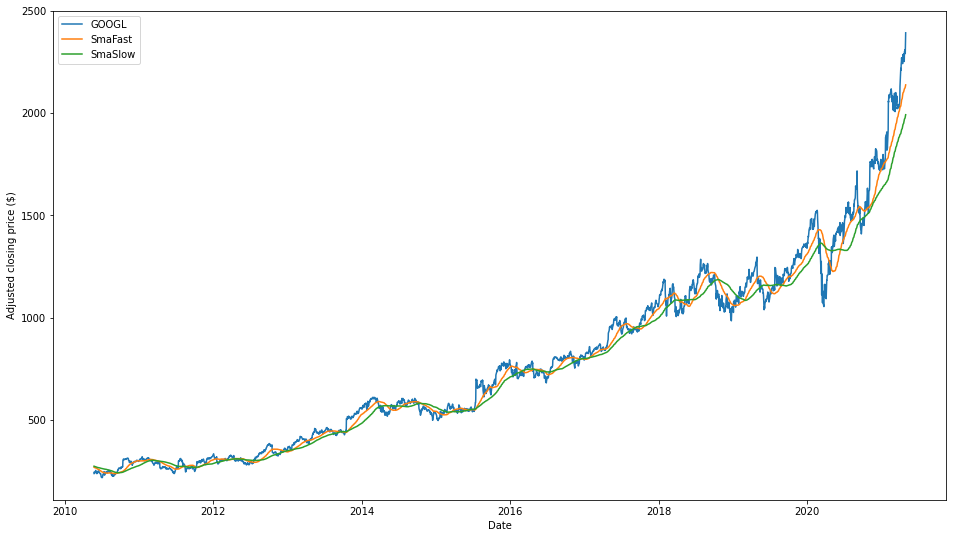

In [13]:
# Plot out the strategy
# We long/buy apple stock or derivatives if Fast Simple Moving Average is above Slow moving average 

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(stock.index, stock['price'], label= symbol)
ax.plot(stock.index, stock['SmaFast'], label='SmaFast')
ax.plot(stock.index, stock['SmaSlow'], label='SmaSlow')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted closing price ($)')
ax.legend()


In [14]:
np.exp(stock[['Return','Strategy']].sum())

Return      10.021034
Strategy     0.554310
dtype: float64

In [15]:
# caculate the annualized volatility
stock[['Return','Strategy']].std()*252**0.5

Return      0.259288
Strategy    0.259607
dtype: float64

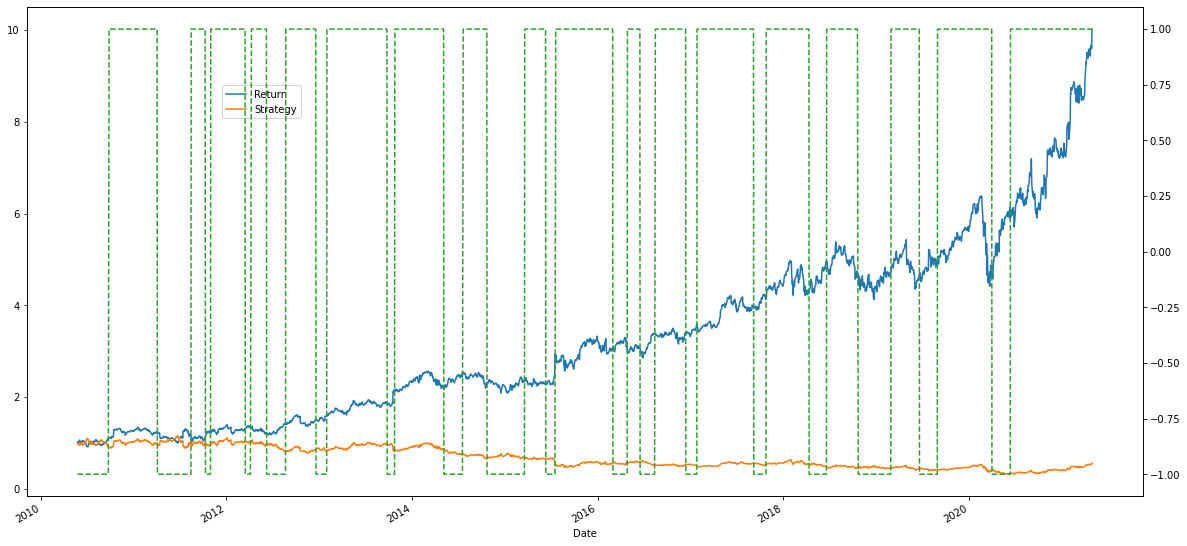

In [16]:
ax = stock[['Return', 'Strategy']].cumsum().apply(np.exp).plot(figsize =(20,10))
stock['Position'].plot(ax = ax, secondary_y ='Position', style = '--')
ax.get_legend().set_bbox_to_anchor((0.25,0.85))


In [17]:
stock.head()

,price,SmaFast,SmaSlow,Position,Return,Strategy
Date,,,,,,
2010-05-26,237.972977,268.733932,273.918718,-1,-0.003359,0.003359
2010-05-27,245.475479,267.982181,273.236586,-1,0.031040,-0.031040
2010-05-28,243.058060,267.173672,272.544093,-1,-0.009897,0.009897
2010-06-01,241.426422,266.396595,271.914013,-1,-0.006736,0.006736
2010-06-02,246.931931,265.754654,271.409859,-1,0.022548,-0.022548


### Use recurrent neural network model: LSTM to predict stock price

An extremly nice blog posts about LSTM, Long and Short term memory model
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/
* http://karpathy.github.io/2015/05/21/rnn-effectiveness/

* LSTM is a recurrent neural networks, it suitable for time series modelling. 
* A recurrent neural network can be thought of as multiple copies of the same network, each passing a message to a successor. 


In [18]:
# First make a copy of cleaned dataframe 
data = stock

In [19]:
# only keep Adj Close(price) as a dataframe
PRICE = data.filter(['price'])
# convert the dataframe to a numpy array 
dataset = PRICE.values 
# Here we use 80% of the data as training data
train_data_len = math.ceil(len(dataset)* .8)
train_data_len

2201

#### Normalizing the Data and split data into training & testing sets

In [20]:
# Scale the data and transform it into a 0 to 1 range 
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0090686 ],
       [0.01251881],
       [0.0114071 ],
       ...,
       [0.95319397],
       [0.98449305],
       [1.        ]])

In [21]:
# Create training data set
# row: 0 to the lenght of training data, and get all the columns 
train_data = scaled_data[0: train_data_len, :]

In [22]:
# split the data into x_train, y train 
x_train =[]
y_train =[]
for i in range (50, len(train_data)):
    x_train.append(train_data[i-50:i,0])
    y_train.append(train_data[i,0])
    if i <= 51:
        print(x_train)
        print(y_train)
        print()

[array([0.0090686 , 0.01251881, 0.0114071 , 0.01065675, 0.01318859,
       0.01600354, 0.01441998, 0.01138178, 0.01121145, 0.00873486,
       0.01172473, 0.01206768, 0.01084549, 0.01425197, 0.01500691,
       0.01473301, 0.0147215 , 0.01208148, 0.0115498 , 0.0105831 ,
       0.00898343, 0.00842643, 0.00828833, 0.00418675, 0.00204389,
       0.00078717, 0.00011048, 0.        , 0.00325226, 0.00471613,
       0.00723186, 0.00915146, 0.0122288 , 0.01272135, 0.0133382 ,
       0.00541814, 0.00693034, 0.01047722, 0.00953583, 0.01121836,
       0.01242673, 0.01217586, 0.01301827, 0.01111248, 0.01125979,
       0.01122756, 0.0125073 , 0.0123738 , 0.01616926, 0.01657896])]
[0.01476524115495588]

[array([0.0090686 , 0.01251881, 0.0114071 , 0.01065675, 0.01318859,
       0.01600354, 0.01441998, 0.01138178, 0.01121145, 0.00873486,
       0.01172473, 0.01206768, 0.01084549, 0.01425197, 0.01500691,
       0.01473301, 0.0147215 , 0.01208148, 0.0115498 , 0.0105831 ,
       0.00898343, 0.00842643, 0.00

In [23]:
# convert the x_train , y_train to numpy arrays
# LSTM model is expecting 3 dimensional data, but we only have 2 dimensional --> reshape the data
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(2151, 50, 1)

#### Build And Compile the Model 

* That return sequences return the hidden state output for each input time step.
* The model has 50 neurons and 1 hidden layer 

In [24]:
# Build the LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences =True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences =False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

2021-12-30 10:20:57.444930: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Train the model 

"On sequence prediction problems, it may be desirable to use a large batch size when training the network and a batch size of 1 when making predictions in order to predict the next step in the sequence."

There is an intereting reading about batch_size on machinelearningmastery.com:
https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/


In [25]:
# train the model 
model.fit(x_train,y_train, batch_size =1, epochs =1)

2021-12-30 10:20:57.873739: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


2151/2151 [==============================] - 32s 14ms/step - loss: 3.4826e-04


In [26]:
# create test data set
test_data = scaled_data[train_data_len -50:, :]
x_test = []
y_test = dataset[train_data_len:, :]
for i in range(50, len(test_data)):
    x_test.append(test_data[i-50:i,0])

x_test = np.array(x_test)

In [27]:
# reshape the data, becasue the lstm model is expecting a 3 dimensional dataset 
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [28]:
# Use the model to predict the value 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions 

array([[1094.4832],
       [1093.7639],
       [1093.8546],
       [1094.4238],
       [1095.571 ],
       [1099.254 ],
       [1104.2329],
       [1111.0029],
       [1117.3792],
       [1121.3322],
       [1123.5979],
       [1127.9509],
       [1134.6781],
       [1141.9521],
       [1147.9652],
       [1152.4618],
       [1155.5149],
       [1159.0306],
       [1164.9338],
       [1172.3136],
       [1176.4451],
       [1177.5233],
       [1176.1892],
       [1172.5543],
       [1167.6228],
       [1163.1423],
       [1161.7916],
       [1162.7814],
       [1165.3962],
       [1169.4657],
       [1172.9012],
       [1175.3392],
       [1176.4155],
       [1177.133 ],
       [1177.9155],
       [1180.0652],
       [1183.0073],
       [1186.5873],
       [1190.9591],
       [1195.3389],
       [1200.57  ],
       [1207.4169],
       [1213.051 ],
       [1218.3019],
       [1223.8335],
       [1230.8876],
       [1227.1228],
       [1216.1396],
       [1202.1853],
       [1190.8665],


### Evaluate The Model

In [29]:
# Get the mean squared error (RMSE), the lower the value of RMSE, the better the model fits
rsme = np.sqrt(np.mean(predictions - y_test)**2)
rsme

57.91403009588068

In [30]:
# create a validation dataset
train = data.iloc[: train_data_len]
finalDF = data.iloc[ train_data_len:]
finalDF['Predictions'] = predictions


/var/folders/k3/1lf551f54pvcy1bpp1lld73r0000gp/T/ipykernel_1044/1989878010.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalDF['Predictions'] = predictions


#### Visualize the Model's Prediction

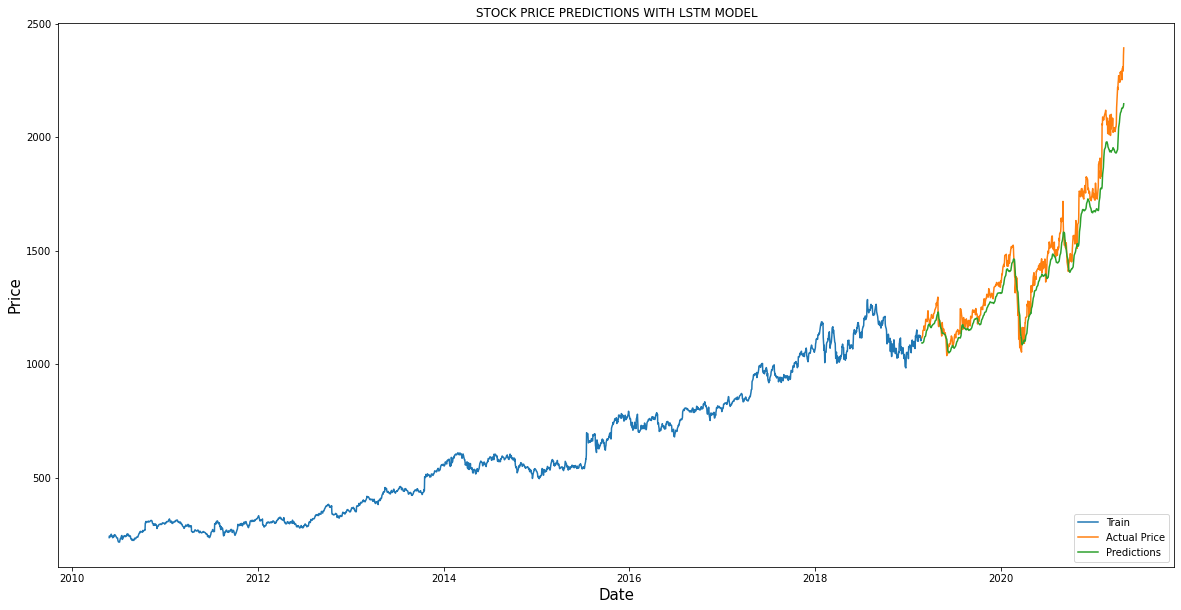

In [31]:
# plot out the actual price and the 
plt.figure(figsize =(20,10))
plt.title('STOCK PRICE PREDICTIONS WITH LSTM MODEL')
plt.xlabel('Date', fontsize = 15)
plt.ylabel('Price', fontsize =15)
plt.plot(train['price'])
plt.plot(finalDF[['price', 'Predictions']])
plt.legend(['Train','Actual Price','Predictions'], loc ='lower right')
plt.show()

The plot above showed us that:

* The blue line: training data
* The orange line is the actual price 
* The green line is the predciton that LSTM model made 

We can see that the predicted price follows the trend of actual price pretty well, but tends to be a little bit higher than the actual.

In [32]:
# show the actual and predicted price
finalDF.tail()

,price,SmaFast,SmaSlow,Position,Return,Strategy,Predictions
Date,,,,,,,
2021-04-23,2299.929932,2119.338799,1970.746195,1,0.020829,0.020829,2126.865234
2021-04-26,2309.929932,2123.762397,1976.301494,1,0.004339,0.004339,2129.531006
2021-04-27,2290.979980,2127.681396,1981.257694,1,-0.008238,-0.008238,2134.318359
2021-04-28,2359.040039,2132.648198,1986.598395,1,0.029275,0.029275,2137.297119
2021-04-29,2392.760010,2138.130996,1992.307595,1,0.014193,0.014193,2147.009766


#### After building the model, now we're going to predict prices of other stocks and financial asset

The model is trained with Google's stock price. To see how this model perform, now we're going to use this model to predict different asset class: such as stock index and digital currency. 

 Predict Google stock price

In [33]:
# Define a function that download data and predict price of the desired financial asset
def predict_price(symbol,startdate,enddate,interval):
    '''
    input: symbol of the stock/financial instrument as a string
    input: startdate & enddate & interval as string
    output: predicted price for the next dag
    '''
    DFPred = download_data(symbol, startdate, enddate,interval)
    DFPred = DFPred.filter(['Adj Close'])
    # Get the last 50 day Adj Close price and convert the df into an array
    last_50_days = DFPred[-50:].values
    # Transform the data into value between 0 and 1
    last_50_days_scaled = scaler.transform(last_50_days)
    # Creat an empty list and append the last 50 days and convert it into numply array 
    X_test =[]
    X_test.append(last_50_days_scaled)
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
    # Get the predicted scaled price and undo the scaling
    pred_price = model.predict(X_test)
    pred_price = scaler.inverse_transform(pred_price)
    str_pred = str(pred_price[0][0])
    print( "The predicted price is " + str_pred)

In [34]:
symbol = "AAPL"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"

predict_price(symbol, startdate, enddate, interval)

[*********************100%***********************]  1 of 1 completed
The predicted price is 170.43695


In [35]:
# Take a look of the actual price of Nov 2021
AAPL_price = download_data("AAPL", "2021-12-01", "2021-12-02","1d")
AAPL_price

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500


#### Save the Model 

In [36]:
# Pretty decent result, now lets save the model 
model.save('model.h5')

In [37]:
# Run the model in the future by load the model 
model = keras.models.load_model('model.h5')

##### Let's use the model to predict the price of other stock and financial asset


In [38]:
symbol = "AMZN"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)

[*********************100%***********************]  1 of 1 completed
The predicted price is 3086.0042


In [39]:
new = download_data(symbol, "2021-12-01", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,3563.5,3585.770020,3492.010010,3507.070068,3507.070068,4001100
2021-12-01,3545.0,3559.879883,3441.600098,3443.719971,3443.719971,3745800


##### Evaluate the model and use the model to predict the price of Amsterdam AEX index

In [40]:
symbol = "^AEX"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)


[*********************100%***********************]  1 of 1 completed
The predicted price is 793.1213


In [41]:
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-30,778.570007,786.840027,774.309998,777.390015,777.390015,154400
2021-12-01,783.840027,792.159973,783.840027,790.700012,790.700012,90800


##### Use the Model to predict the price of Microsoft stock

In [42]:
symbol = "MSFT"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)


[*********************100%***********************]  1 of 1 completed
The predicted price is 341.27713


In [43]:
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-29,334.940002,339.029999,334.739990,336.630005,336.630005,28563500
2021-11-30,335.320007,337.779999,328.989990,330.589996,330.589996,42885600
2021-12-01,335.130005,339.279999,329.390015,330.079987,330.079987,33337600


##### Use mthe Model to predict the price of bitcoin

In [46]:
symbol = "BTC-USD"
startdate = "2021-01-01"
enddate = "2021-11-30"
interval = "1d"
predict_price(symbol, startdate, enddate, interval)


[*********************100%***********************]  1 of 1 completed
The predicted price is 6284.603


In [47]:
new = download_data(symbol, "2021-11-30", "2021-12-02","1d")
new

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-11-29,57291.906250,58872.878906,56792.527344,57806.566406,57806.566406,32370840356
2021-11-30,57830.113281,59113.402344,56057.281250,57005.425781,57005.425781,36708594618
2021-12-01,56907.964844,59041.683594,56553.082031,57229.828125,57229.828125,36858195307


Took a look of this result, the model's prediction of Bitcoin price is not even close to the actual price at all. It might have something to do with the fact that we have trained this model with a tech stock data. Difference financial assets have different price movement patterns, they trend in different way. Obviously, Bitcoine is a totally different culture than equity(stocks)

### Conclusion And Possible Improvements

The model does reasonable well when predicting the same asset class and sector, that is : tech stock (equity).  AEX is a miner European Index(Amsterdam Exchange), which contains a basket of stocks across different sectors,  however this index is positively correlated with performance of tech sectors stocks.   

The model does not perform well when predicting the price of Bitcoin which is a totally different asset class. In financial sector, there are many assets classes, such as Fixed Income( Bonds), Equity(stocks), Currency(Forex), Digital Assets(coins).  Different asset classed exhibit different price movements patterns, due to the fact that prices of those assets are determined on different factors.  

Financial market is an extremely complicated system, forecasting price movements is as difficult as forecasting weather. Efficient market hypothesis assumes that the price of a financial assets already priced in all the information that determine the price, however this is simple not true in reality. Details of assets pricing models and efficient market hypothesis is beyond the scope of this project. To summaries, the LTSM is just too simply to forecast stock price, and trader&investor should definitely not trade according to the predictions.  One of the easiest way to improve curre nt model is to add more hidden layers.  A more complicated way would be build an event driven architecture with multiple models that trained with data from different assets classes. And a model trained with equity data should never been used to predict the price of other asset classes. 

